In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import numpy as np
from tqdm import tqdm

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import rasterio
import rioxarray as rio
import xarray as xa

import haversine

from coralshift.processing import data
from coralshift.utils import file_ops, directories
from coralshift.dataloading import bathymetry
from coralshift.plotting import spatial_plots

from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker


# Allen Coral Atlas Dataset
For the Great Barrier Reef and Torres Strait. Excellent visualisation [here](https://allencoralatlas.org/atlas/#4.55/-16.5163/147.1100).

## Load in `reefextent` and `benthic` files

**`reefextent`**

Set of shapely objects showing presence of "reef" – e.g. "a ridge of jagged rock, coral, or sand just above or below the surface of the sea." 

**`benthic`**

Set of shapely objects labelled with reef class:

| Class           	| Number of polygons 	|
|-----------------	|--------------------	|
| Coral/Algae     	| 877787             	|
| Rock            	| 766391             	|
| Rubble          	| 568041             	|
| Sand            	| 518805             	|
| Microalgal Mats 	| 27569              	|


In [3]:
reef_extent_dir = Path("/Volumes/MRes Drive/reef_baseline/Allen_atlas/Great-Barrier-Reef-and-Torres-Strait-20230310013521/Reef-Extent")

df_reef_extent = file_ops.check_pkl_else_read_gpkg(reef_extent_dir, "reefextent")
# map dataframe class names to values
class_vals = {"Reef": 1, "Coral/Algae": 2, "Rock": 3, "Rubble": 4, "Sand": 5, "Microalgal Mats": 6, "Seagrass": 7}
df_reef_extent['class_val'] = df_reef_extent['class'].map(class_vals)

df_reef_extent.head()

Reading /Volumes/MRes Drive/reef_baseline/Allen_atlas/Great-Barrier-Reef-and-Torres-Strait-20230310013521/Reef-Extent/reefextent.pkl
reefextent read from reefextent.pkl


,class,geometry,class_val
0,Reef,"POLYGON ((146.86833 -18.02176, 146.87060 -18.0...",1
1,Reef,"POLYGON ((146.87554 -18.01891, 146.87599 -18.0...",1
2,Reef,"POLYGON ((146.37751 -17.74124, 146.37770 -17.7...",1
3,Reef,"POLYGON ((146.46510 -17.25820, 146.46469 -17.2...",1
4,Reef,"POLYGON ((146.48322 -17.25149, 146.48288 -17.2...",1


In [4]:
# N.B. takes ~10 minutes to read whole area from gpkg: faster if pickle version present
benthic_extent_dir = Path("/Volumes/MRes Drive/reef_baseline/Allen_atlas/Great-Barrier-Reef-and-Torres-Strait-20230310013521/Benthic-Map")

df_benthic = file_ops.check_pkl_else_read_gpkg(benthic_extent_dir, "benthic")
# map dataframe class names to values
df_benthic['class_val'] = df_benthic['class'].map(class_vals)

df_benthic.head()

Reading /Volumes/MRes Drive/reef_baseline/Allen_atlas/Great-Barrier-Reef-and-Torres-Strait-20230310013521/Benthic-Map/benthic.pkl
benthic read from benthic.pkl


,class,geometry,class_val
0,Rock,"POLYGON ((146.84549 -18.00053, 146.84553 -18.0...",3
1,Rock,"POLYGON ((146.84576 -18.00116, 146.84589 -18.0...",3
2,Coral/Algae,"POLYGON ((146.84338 -18.00098, 146.84347 -18.0...",2
3,Coral/Algae,"POLYGON ((146.87401 -18.01863, 146.87414 -18.0...",2
4,Coral/Algae,"POLYGON ((146.87302 -18.01940, 146.87311 -18.0...",2


### Rasterize polygons

Rasterized arrays are necessary to process the geospatial data e.g. to align different gridcells. This is carried out at
the specified resolution by `rasterio`'s built-in `features.rasterize` functionality. Default resolution is 1/12 of a
degree, since this is the size of the climate data and can be processed quickly by machine learning models to act as a 
proof-of-concept. Smaller resolutions (closer to 30m/XX degree across) are run on cloud computing servers in the separate
Google Colab notebook for regional predictions.

In [5]:
# # set resolution requirements – not sure it's useful: need more control over it and use it rarely

# def generate_filename(subject: str, suffix: str, resolution: float=1/12, horizontal_distance: float=None) -> str:
    
#     if horizontal_distance:
#         resolution = data.distance_to_degree()
#     return "_".join((subject, "{0:.3g}".format(resolution), "degree")) + file_ops.pad_suffix(suffix)

# generate_filename('coral', 'nc', 0.03)


In [6]:
# rasterise reef extent dataframe and return as xarray dataset (which is saved to an .nc file)
xa_reef_1_12 = data.check_nc_exists_generate_raster_xa(
    dir_path = "/Volumes/MRes Drive/reef_baseline/Allen_atlas/Great-Barrier-Reef-and-Torres-Strait-20230310013521/Processed",
    filename = "reef_1_12.nc", 
    xa_ds = df_reef_extent, 
    resolution = 1/12,
    class_col = "class_val",
    xa_name = "reef_extent_1_12_degree",
    all_touched = True
)

reef_1_12.nc already exists in /Volumes/MRes Drive/reef_baseline/Allen_atlas/Great-Barrier-Reef-and-Torres-Strait-20230310013521/Processed. No new files written.


In [7]:
# rasterise coral dataframe and return as xarray dataset (which is saved to an .nc file)
xa_coral_1_12 = data.check_nc_exists_generate_raster_xa(
    dir_path = "/Volumes/MRes Drive/reef_baseline/Allen_atlas/Great-Barrier-Reef-and-Torres-Strait-20230310013521/Processed",
    filename = "coral_1_12.nc",
    xa_ds = df_benthic[df_benthic["class"] == "Coral/Algae"], 
    resolution = 1/12,
    class_col = "class_val",
    xa_name = "coral_algae_1_12_degree",
    all_touched = True
    )

coral_1_12.nc already exists in /Volumes/MRes Drive/reef_baseline/Allen_atlas/Great-Barrier-Reef-and-Torres-Strait-20230310013521/Processed. No new files written.


In [8]:
# this takes literally months

# xa_coral_30m = data.check_nc_exists_generate_raster_xa(
#     dir_path = "/Volumes/MRes Drive/reef_baseline/Allen_atlas/Great-Barrier-Reef-and-Torres-Strait-20230310013521/Processed",
#     filename = "coral_30m.nc",
#     xa_ds = df_benthic[df_benthic["class"] == "Coral/Algae"], 
#     horizontal_distance = 30,
#     class_col = "class_val",
#     xa_name = "coral_algae_30m",
#     all_touched = True
#     )

# Load in climate data

In [9]:
gor_monthly_dir = Path("/Volumes/MRes Drive/global_ocean_reanalysis/monthly_means/baseline_area")
gor_monthly = file_ops.load_merge_nc_files(gor_monthly_dir)
gor_monthly

<xarray.Dataset>
Dimensions:    (time: 336, latitude: 205, longitude: 157, depth: 17)
Coordinates:
  * latitude   (latitude) float32 -25.0 -24.92 -24.83 ... -8.167 -8.083 -8.0
  * depth      (depth) float32 0.494 1.541 2.646 3.819 ... 29.44 34.43 40.34
  * time       (time) datetime64[ns] 1993-01-16T12:00:00 ... 2020-12-16T12:00:00
  * longitude  (longitude) float32 140.0 140.1 140.2 140.2 ... 152.8 152.9 153.0
Data variables:
    mlotst     (time, latitude, longitude) float32 dask.array<chunksize=(72, 205, 157), meta=np.ndarray>
    siconc     (time, latitude, longitude) float32 dask.array<chunksize=(72, 205, 157), meta=np.ndarray>
    thetao     (time, depth, latitude, longitude) float32 dask.array<chunksize=(72, 17, 205, 157), meta=np.ndarray>
    usi        (time, latitude, longitude) float32 dask.array<chunksize=(72, 205, 157), meta=np.ndarray>
    sithick    (time, latitude, longitude) float32 dask.array<chunksize=(72, 205, 157), meta=np.ndarray>
    bottomT    (time, latitude, longitude) float32 dask.array<chunksize=(72, 205, 157), meta=np.ndarray>
    vsi        (time, latitude, longitude) float32 dask.array<chunksize=(72, 205, 157), meta=np.ndarray>
    vo         (time, depth, latitude, longitude) float32 dask.array<chunksize=(72, 17, 205, 157), meta=np.ndarray>
    uo         (time, depth, latitude, longitude) float32 dask.array<chunksize=(72, 17, 205, 157), meta=np.ndarray>
    so         (time, depth, latitude, longitude) float32 dask.array<chunksize=(72, 17, 205, 157), meta=np.ndarray>
    zos        (time, latitude, longitude) float32 dask.array<chunksize=(72, 205, 157), meta=np.ndarray>
Attributes: (12/17)
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

In [10]:
# for now, approximate all as being flat (selecting top depth layer)
gor_monthly = gor_monthly.sel(depth=0.494025)
# # could also broadcast: will figure out how best to deal with this later
# (broadcasted_gor_monthly,) = xa.broadcast(gor_monthly)

In [11]:
gor_monthly

<xarray.Dataset>
Dimensions:    (time: 336, latitude: 205, longitude: 157)
Coordinates:
  * latitude   (latitude) float32 -25.0 -24.92 -24.83 ... -8.167 -8.083 -8.0
    depth      float32 0.494
  * time       (time) datetime64[ns] 1993-01-16T12:00:00 ... 2020-12-16T12:00:00
  * longitude  (longitude) float32 140.0 140.1 140.2 140.2 ... 152.8 152.9 153.0
Data variables:
    mlotst     (time, latitude, longitude) float32 dask.array<chunksize=(72, 205, 157), meta=np.ndarray>
    siconc     (time, latitude, longitude) float32 dask.array<chunksize=(72, 205, 157), meta=np.ndarray>
    thetao     (time, latitude, longitude) float32 dask.array<chunksize=(72, 205, 157), meta=np.ndarray>
    usi        (time, latitude, longitude) float32 dask.array<chunksize=(72, 205, 157), meta=np.ndarray>
    sithick    (time, latitude, longitude) float32 dask.array<chunksize=(72, 205, 157), meta=np.ndarray>
    bottomT    (time, latitude, longitude) float32 dask.array<chunksize=(72, 205, 157), meta=np.ndarray>
    vsi        (time, latitude, longitude) float32 dask.array<chunksize=(72, 205, 157), meta=np.ndarray>
    vo         (time, latitude, longitude) float32 dask.array<chunksize=(72, 205, 157), meta=np.ndarray>
    uo         (time, latitude, longitude) float32 dask.array<chunksize=(72, 205, 157), meta=np.ndarray>
    so         (time, latitude, longitude) float32 dask.array<chunksize=(72, 205, 157), meta=np.ndarray>
    zos        (time, latitude, longitude) float32 dask.array<chunksize=(72, 205, 157), meta=np.ndarray>
Attributes: (12/17)
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

In [12]:
var_dict = {"mlotst": "ocean mixed layer thickness (sigma theta)", "siconc": "sea ice area fraction", 
    "thetao": "sea water potential temperature", "usi": "eastward sea ice velocity", "sithick": "sea ice thickness",
    "bottomT": "sea water potential at sea floor", "vsi": "northward sea ice velocity", 
    "usi": "eastward sea ice velocity", "vo": "northward sea water velocity", "uo": "eastward sea water velocity", 
    "so": "sea water salinity", "zos": "sea surface height above geoid"}

The following variables returned empty arrays, and so are not plotted: ['sithick', 'usi', 'siconc', 'vsi']


100%|██████████| 7/7 [00:00<00:00,  9.10it/s]


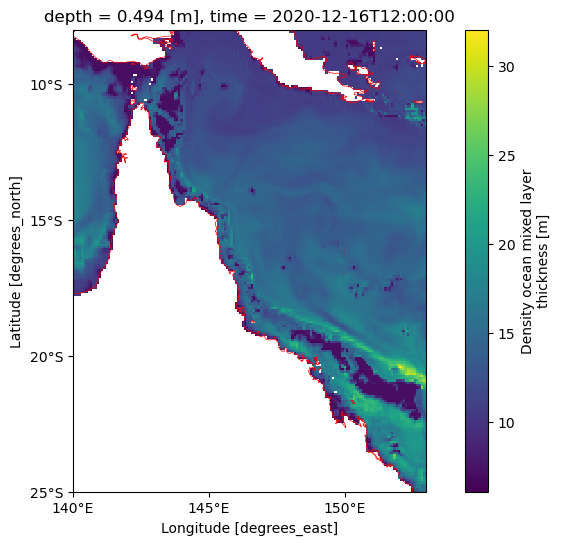

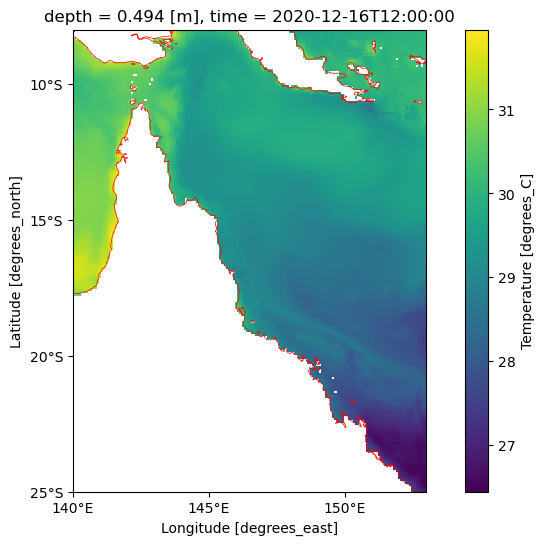

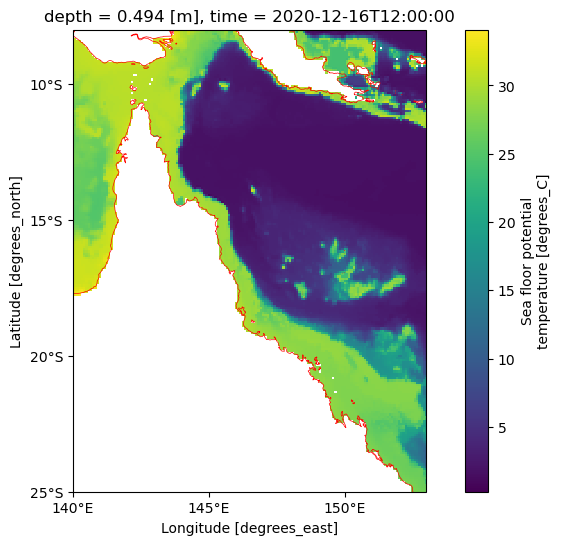

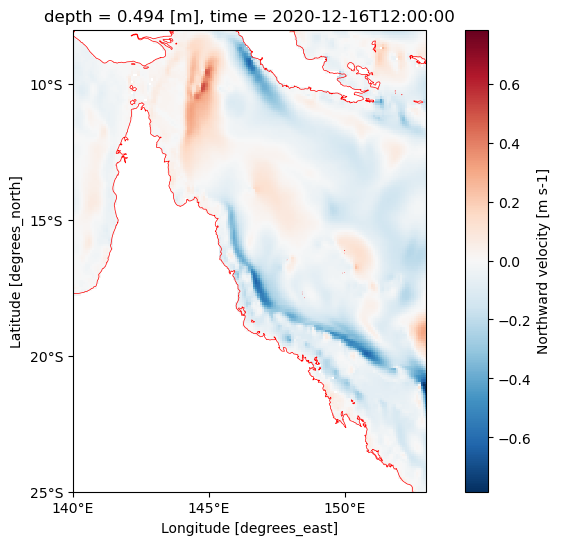

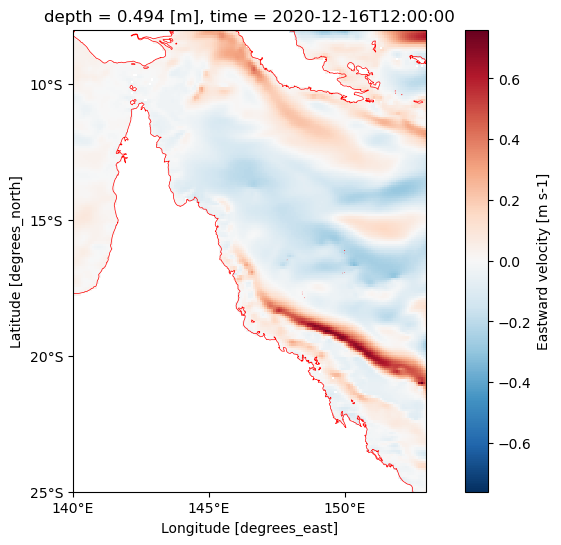

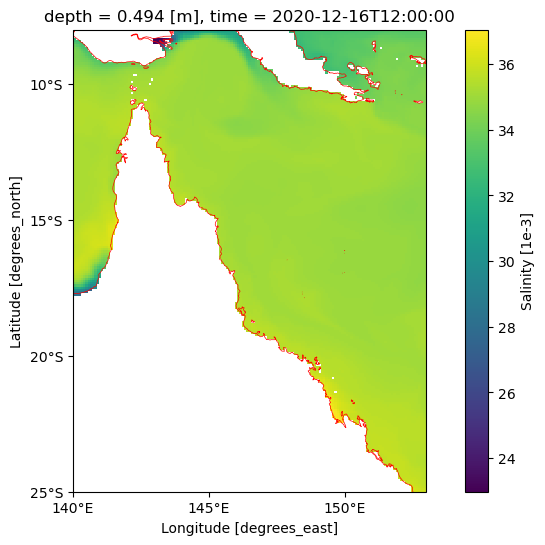

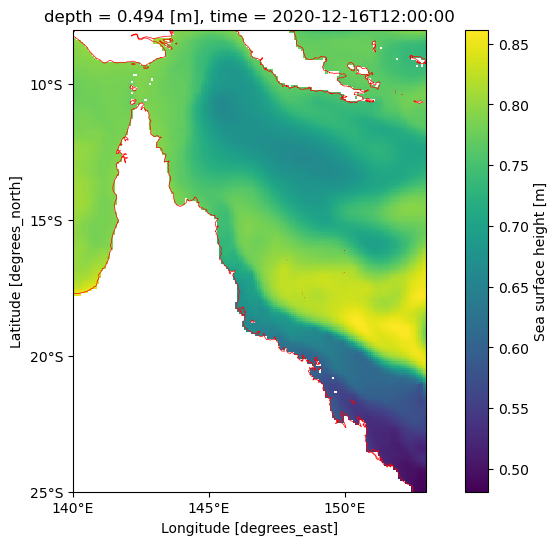

In [13]:
spatial_plots.plot_vars_at_time(gor_monthly, variable_dict=var_dict)

In [ ]:
spatial_plots.generate_like_variable_timeseries_gifs(gor_monthly.isel(time=slice(None, 2)))

In [ ]:
# Plot animations within notebook: with imperfect colourbars and screwing pretty much everything else up

# %matplotlib inline
# from IPython.display import HTML

# ani=spatial_plots.generate_variable_timeseries_gif(gor_monthly["bottomT"].isel(time=slice(None, 2)))
# HTML(ani.to_html5_video())

# Load in bathymetric data

In [ ]:
# 30m GBR bathymetry (can visualise ETOPO later if necessary)
gbr_30_dir = Path(directories.get_volume_dir("MRes Drive"), "bathymetry/GBR_30m")
# download any missing data
bathymetry.download_30m_gbr_bathymetry(download_dest_dir=gbr_30_dir)
# fetch data
gbr_30_files = file_ops.return_list_filepaths(gbr_30_dir, ".tif")

In [ ]:
# generate dictionary of file names and arrays: {filename: xarray.DataArray, ...}
gbr_30_dict_preprocess = data.tifs_to_xa_array_dict(gbr_30_files)
# process xa_arrays (drop unnecessary coordinates) and upsample to 1/12 degree to make quicker to handle
gbr_30_dict = data.process_xa_arrays_in_dict(gbr_30_dict_preprocess, coords_to_drop=["band"])
# upsample xa_arrays in dict to 1/12 degree to make quicker to handle
bathymetry_1_12_dict = data.upsample_dict_of_xa_arrays(gbr_30_dict, resolution=1/12)

In [ ]:
list(bathymetry_1_12_dict.keys())

In [ ]:
def list_of_xa_arrays_from_dict(xa_dict: dict) -> list[xa.Dataset]:
    array_list = []
    for array in xa_dict.values():
        array_list.append(array)
    return array_list

def merge_dict_of_xa_arrays(xa_dict: dict, xa_da_name: str="unnamed") -> xa.Dataset:
    array_list = list_of_xa_arrays_from_dict(xa_dict)
    # return xa.merge(array_list).rename(xa_da_name)
    merged = xa.merge(array_list)
    merged["name"] = xa_da_name
    return merged


def concat_dict_of_xa_arrays(xa_dict: dict, dim: str = "combined", xa_da_name: str="unnamed") -> xa.DataArray:
    array_list = list_of_xa_arrays_from_dict(xa_dict)
    concatenated = xa.concat(array_list, dim)
    concatenated["name"] = xa_da_name
    return concatenated

In [ ]:
xa_bathymetry_1_12 = merge_dict_of_xa_arrays(bathymetry_1_12_dict, "1_12_bathymetry")
xa_bathymetry_1_12

In [ ]:
xa_bathymetry_1_12

In [ ]:
xa_bathymetry_1_12["Great_Barrier_Reef_D_2020_30m_MSL_cog.tif"].plot()

In [ ]:
list(bathymetry_1_12_dict.keys())[0]

In [ ]:
test_out = xa.concat([xa_bathymetry_1_12[list(bathymetry_1_12_dict.keys())[0]],
    xa_bathymetry_1_12[list(bathymetry_1_12_dict.keys())[1]],
    xa_bathymetry_1_12[list(bathymetry_1_12_dict.keys())[2]]
    ], dim="location")

In [ ]:
concatted_bath = concat_dict_of_xa_arrays(bathymetry_1_12_dict, xa_da_name="1_12_bathymetry")

In [ ]:
concatted_bath

In [ ]:
# combine bathymetry tiles into xarray: nan values where data doesn't exist
# xa_array_all_bathymetry = 
concatted_bath["combined"].plot()


In [ ]:
gbr_30_dict["Great_Barrier_Reef_D_2020_30m_MSL_cog.tif"]

### Align coral baseline, climate data, and bathymetry

In [ ]:
# at 1/12 degree resolution

# reassign "class 2" (coral/algae) to values of 0 and 1 for later lstm target
xa_coral_1_12['coral_algae_1-12_degree'] = xa_coral_1_12['coral_algae_1-12_degree'].where(
    xa_coral_1_12['coral_algae_1-12_degree'] != 2, 1)
coral_climate_1_12_interped = gor_monthly.interp_like(xa_coral_1_12, method="linear")
coral_climate_1_12 = xa.merge([xa_coral_1_12,coral_climate_1_12_interped])
# broadcast coral presence with time
(coral_climate_1_12,) = xa.broadcast(coral_climate_1_12)

In [ ]:
coral_climate_1_12

In [ ]:
# save lstm-ready(ish) array to nc for passing to model
dir_path = Path("/Volumes/MRes Drive/reef_baseline/Allen_atlas/Great-Barrier-Reef-and-Torres-Strait-20230310013521/Processed")
filename = "coral_climate_1_12.nc"
filepath = dir_path / filename

coral_1_12_climate.to_netcdf(filepath)

# Set up LSTM

In [ ]:
coral_1_12_climate["bottomT"].sel(time="2020-12-16T12:00:00.000000000").plot()

In [ ]:
lstm_array = data.xa_ds_to_3d_numpy(gor_monthly)

In [ ]:
lstm_array.shape

In [ ]:
# merge with coral (start with tests size)
# merge with bathymetry
# throw this into an lstm
# visualise weather data
# write up/plot other reef baselines

In [ ]:
xa_timeseries = xa.merge([broadcasted_no_ice,xa_coral])
xa_timeseries

In [ ]:
(lstm_xarray,) = xa.broadcast(xa_timeseries)
lstm_xarray

In [ ]:
lstm_interped = broadcasted_no_ice.interp_like(xa_coral, method="linear")
lstm_combined = xa.merge([xa_coral,lstm_interped])
(broadcasted_no_ice,) = xa.broadcast(lstm_combined)

In [ ]:
xarray_coords_limits(broadcasted_no_ice)

In [ ]:
broadcasted_no_ice["mlotst"].sel(depth=0.494025,time='2020-12-16T12:00:00.000000000').plot()

In [ ]:
f, lstm_ax = plt.subplots(figsize=[6,6])

# lstm_xarray["mlotst"].sel(depth=lstm_xarray.depth.values[0], time=lstm_xarray.time.values[0]).plot(ax=lstm_ax)
broadcasted_no_ice["vo"].sel(depth=broadcasted_no_ice.depth.values[0], time=broadcasted_no_ice.time.values[-1]).plot(
    ax=lstm_ax)
[ylims,xlims,_,_] = xarray_coords_limits(broadcasted_no_ice)

lstm_ax.set_xlim(xlims)
lstm_ax.set_ylim(ylims)
lstm_ax.set_aspect("equal")

In [ ]:
flat_vars = ["zos","mlotst","bottomT","sithick","siconc","usi","vsi"]

month_datasets = [data_dict[month][flat_vars] for month in sorted(data_dict.keys())]
flat_vars_ds = xa.concat(month_datasets, dim='time')

In [ ]:
# f, ax_coral = plt.subplots()

cipher = {"Reef": 1, "Coral/Algae": 2, "Rock": 3, "Rubble": 4, "Sand": 5, "Microalgal Mats": 6, "Seagrass": 7}

df_benthic['class_val'] = df_benthic['class'].map(cipher)
#RERUN ONLY IF NECESSARY
raster_benthic_coral, (xmin, ymin, xmax, ymax) = rasterize_shapely_df(df_benthic[df_benthic["class"] == "Coral/Algae"], "class_val", resolution=1/12)
# TODO: include naming of xa
xa_coral = xa_array_from_raster(raster_benthic_coral, (ymin,ymax), (xmin,xmax), resolution=1/12)
# xa_coral.plot(ax=ax_coral)
# ax_coral.axis('equal')

In [ ]:
flat_vars_ds

In [ ]:
merged = xa.merge([flat_vars_ds,xa_coral])
merged

In [ ]:
xa_coral = xa_coral.rename("limited coral")

In [ ]:
xa_coral

In [ ]:
xarray_coords_limits(flat_vars_ds)

In [ ]:
xa_xa_coral

In [ ]:
f,ax_all_coral = plt.subplots(1,2, figsize=[16,8])
[ylims,xlims] = xarray_coords_limits(xa_coral)

xa_coral.plot(ax=ax_all_coral[0], vmin=0, vmax=1)
flat_vars_ds["zos"][0].plot(ax=ax_all_coral[1])

for ax in ax_all_coral:
    ax.set_aspect("equal")
    ax.set_ylim(ylims)
    ax.set_xlim(xlims)

In [ ]:
interped = flat_vars_ds.interp_like(xa_coral, method="linear")
combined = xa.merge([xa_coral,interped])
(broadcasted,) = xa.broadcast(combined)

In [ ]:
broadcasted["limited coral"].sel(time=broadcasted.time[1].values).plot()

In [ ]:
list(broadcasted.data_vars)

In [ ]:
data_vars = list(combined.data_vars)
num_vars = len(data_vars)

In [ ]:
# any("time" for el in list(combined[data_vars[1]].coords))
# combined[data_vars[1]][0].plot()
broadcasted[data_vars[1]].sel(time=broadcasted.time[1].values).plot()

In [ ]:
broadcasted.time

In [ ]:
f,ax=plt.subplots(figsize=[6,6])
broadcasted_no_ice["limited coral"].sel(
        time=broadcasted_no_ice.time[-1].values, depth=broadcasted_no_ice.depth.values[0]).plot(ax=ax)

ax.set_xlim(145,145.6)
ax.set_ylim(-15,-14)

In [ ]:
time = xa.cftime_range(start='2022-01-01', end='2022-01-05', freq='D')

# create lat and lon coordinates
lat = np.linspace(-90, 90, 5)
lon = np.linspace(-180, 180, 5)

# create random data for each coordinate
# create random data for each variable and coordinate
data1 = np.random.rand(len(time), len(lat), len(lon))
data2 = np.random.rand(len(time), len(lat), len(lon))
data3 = np.random.rand(len(time), len(lat), len(lon))

# create xarray dataset with time, lat, and lon as coordinates
ds = xa.Dataset({'data1': (['time', 'lat', 'lon'], data1),
                 'data2': (['time', 'lat', 'lon'], data2),
                 'data3': (['time', 'lat', 'lon'], data3)},
                coords={'time': time,
                        'lat': lat,
                        'lon': lon})


# stacked.transpose('time','points').as_numpy()

# np.shape(stacked['data1'].transpose('time','points').to_numpy())

def stacking(ds):
    stacked = ds.stack(points=('lat', 'lon'))

    vars_list = list(ds.variables)
    stack= stacked[vars_list[0]].to_numpy()

    for d in vars_list[1:]:
        vals = stacked[d].transpose('time','points').to_numpy()
        stack = np.stack([stack, vals], axis=1)

    return stack

stacking(ds)

In [ ]:
ds

In [ ]:
stacked = ds.stack(points=('lat', 'lon'))
num_timesteps = len(ds.time)
stacked

In [ ]:
# stacked.transpose('time','points').as_numpy()

# np.shape(stacked['data1'].transpose('time','points').to_numpy())

def stacking(ds):
    stacked = ds.stack(points=('lat', 'lon'))

    vars_list = list(ds.variables)
    stack= stacked[vars_list[0]].to_numpy()

    for d in vars_list[1:]:
        vals = stacked[d].transpose('time','points').to_numpy()
        stack = np.stack([stack, vals], axis=1)

    return stack

stacking(ds)

In [ ]:
reshaped = stacked.transpose('points', 'time').values
reshaped


In [ ]:
data = broadcasted_no_ice.sel(depth=broadcasted_no_ice.depth.values[0])

stacked = data.stack(points=['latitude', 'longitude', 'time'])

In [ ]:
stacked.indexes["points"][0]

In [ ]:
data.to_dataframe("out").unstack()

In [ ]:
stacked.indexes["points"]

In [ ]:
numpy_array = stacked.values

In [ ]:
numpy_array

In [ ]:
# change this so it plots all variables in an xarray automatically
data_vars = list(broadcasted_no_ice.data_vars)
num_vars = len(data_vars)

num_cols = int(np.ceil(num_vars/3))

f, ax_all = plt.subplots(num_cols, num_cols, figsize=[20,20])
ax_all = ax_all.ravel()

for i, var in tqdm(enumerate(data_vars)):
    # if contains "time" (i.e. not just 2d), plot most recent
    # if any("time" for el in list(combined[data_vars[1]].coords)):
        # combined[var][-1].plot(ax=ax_all[i])
    # else:
    broadcasted_no_ice[var].sel(
        time=broadcasted_no_ice.time[-1].values, depth=broadcasted_no_ice.depth.values[0]).plot(ax=ax_all[i])
    ax_all[i].set_aspect("equal")
    ax_all[i].set_xlim(xlims)
    ax_all[i].set_ylim(ylims)
    # # coords zoomed on coastal area
    # ax_all[i].set_xlim(145,145.6)
    # ax_all[i].set_ylim(-15,-14)

In [ ]:
broadcasted_no_ice["limited coral"].sel(time=broadcasted_no_ice.time[-1].values, depth=broadcasted_no_ice.depth.values[0])

In [ ]:
interped = flat_vars_ds.interp_like(xa_coral, method="zero")
interped = xa.merge([xa_coral, interped])

In [ ]:
f,test_ax = plt.subplots()

climate_interest = flat_vars_ds.sel(latitude=slice(-17,-10), longitude=slice(142,147))
climate_interest["zos"][0].plot(ax=test_ax)
test_ax.set_aspect('equal')
# xa_coral.plot(ax=test_ax)
# climate_interest

In [ ]:
f,coral_ax = plt.subplots()

xa_coral.plot(ax=coral_ax)
coral_ax.set_xlim(142,147)
coral_ax.set_ylim(-17,-10)
# xa_coral.plot(ax=test_ax)
# climate_interest

In [ ]:
f, ax_interped = plt.subplots()
# interped["limited coral"].plot(ax=ax_interped)
interped["bottomT"].plot(ax=ax_interped)

ax_interped.set_xlim(146,147)
ax_interped.set_ylim(-17,-16.5)


In [ ]:
f, ax_lim = plt.subplots()
merged["limited reef extent"].plot(ax=ax_lim)
ax_lim.set_xlim(146,147)
ax_lim.set_ylim(-17,-16.5)

In [ ]:
cipher = {"Reef": 1, "Coral/Algae": 2, "Rock": 3, "Rubble": 4, "Sand": 5, "Microalgal Mats": 6, "Seagrass": 7}

# df_benthic['class_val'] = df_benthic['class'].map(cipher)
df_reef_extent['class_val'] = df_reef_extent['class'].map(cipher)
df_reef_extent.head()

In [ ]:
fig, ax = plt.subplots()
df_reef_extent.plot(ax=ax, column="geometry", label="class")

In [ ]:
# def haversine(lats: tuple[float], lons: tuple[float]):
#     # earth radius in km (~at equator)
#     R = 6356.7523 # this is in miles.

#     dLat = np.radians(lats[1] - lats[0])
#     dLon = np.radians(lons[1] - lats[0])
#     lat1 = np.radians(lats[0])
#     lat2 = np.radians(lats[1])

#     a = np.sin(dLat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dLon/2)**2
#     c = 2*np.arcsin(np.sqrt(a))

#     return R * c
# haversine((0,0.001), (0,0))

In [ ]:
# generate lat lon arrays by specifying start and end lat/lons, and resolution (in m or degrees)

# haversine.haversine((0,0.001), (0,0), unit=haversine.Unit.METERS)
haversine.inverse_haversine((-12,144), 200, direction=haversine.Direction.SOUTH, unit=haversine.Unit.METERS)

In [ ]:
# native resolution (~3.7m)
# raster_reef_extent_highres, (xmin, ymin, xmax, ymax) = rasterize_shapely_df(df_reef_extent[:10], "class_val", resolution=0.000033274853457)
# xa_reef_extent_highres = xa_array_from_raster(raster_reef_extent_highres, (ymin,ymax), (xmin,xmax), resolution=0.000033274853457)
# xa_reef_extent_highres[:4].plot()

In [ ]:
f, ax_reef_extent = plt.subplots()
raster_reef_extent, (xmin, ymin, xmax, ymax) = rasterize_shapely_df(df_reef_extent[:], "class_val", resolution=1/12)
xa_reef_extent = xa_array_from_raster(raster_reef_extent, (ymin,ymax), (xmin,xmax), resolution=1/12)
xa_reef_extent.plot(ax=ax_reef_extent)
ax_reef_extent.axis('equal')

In [ ]:
toy_reef_extent, (xmin, ymin, xmax, ymax) = rasterize_shapely_df(df_reef_extent[:], "class_val", resolution=2)
xa_toy_reef_extent = xa_array_from_raster(toy_reef_extent, (ymin,ymax), (xmin,xmax), resolution=2)
xa_toy_reef_extent.plot()

In [ ]:
from coralshift.utils import directories, file_ops
from coralshift.dataloading import bathymetry
from coralshift.processing import data
# 30m GBR bathymetry (can visualise ETOPO later if necessary)
gbr_30_dir = Path(directories.get_volume_dir("MRes Drive"), "bathymetry/GBR_30m")

# download missing data
bathymetry.download_30m_gbr_bathymetry(download_dest_dir=gbr_30_dir)

# fetch data
gbr_30_files = file_ops.return_list_filepaths(gbr_30_dir, ".tif")
# generate dictionary of file names and arrays: {filename: xarray.DataArray, ...}
gbr_30_dict_preprocess = data.tifs_to_xa_array_dict(gbr_30_files)
# process xa_arrays
gbr_30_dict = data.process_xa_arrays_in_dict(gbr_30_dict_preprocess, coords_to_drop=["band"])

In [ ]:
gbr_30_dict["Great_Barrier_Reef_A_2020_30m_MSL_cog.tif"]

In [ ]:
# haversine.inverse_haversine((-13.5,145.5), 3.7, direction=haversine.Direction.SOUTH, unit=haversine.Unit.METERS)
haversine.haversine((0,0), (0,0.000033274853457), unit=haversine.Unit.METERS) # basically the same, wherever on world

In [ ]:
5/16666

In [ ]:
np.sqrt(len(df_reef_extent)*3.7)

In [ ]:
bath_upsampled_array = data.upsample_xa_array(gbr_30_dict["Great_Barrier_Reef_A_2020_30m_MSL_cog.tif"]).rename("bathymetry")
coords_cipher = {"x": "longitude", "y": "latitude"}
bathymetry = bath_upsampled_array.rename(coords_cipher)
bathymetry

In [ ]:
interped = xa_toy_reef_extent.interp_like(bathymetry, method="zero").rename("reef")
interped

In [ ]:
merged = xa.merge([interped, bathymetry])
merged

In [ ]:
# merged["bathymetry"].plot(vmin=-100,vmax=100)
merged["reef"].plot(vmin=0,vmax=1)

In [ ]:
d1_x_max, d1_y_max = 23,10
num_x, num_y = 2, 2

d1 = np.ones((num_x,num_y))
d1_x = np.linspace(-10,d1_x_max,num_x)
d1_y = np.linspace(0,d1_y_max,num_y)
d2 = np.zeros((100,100))
d2_coords = np.arange(0,100,1)

da1 = xa.DataArray(data=d1, dims=["x","y"], coords={"x":d1_x,"y":d1_y}, name="da1")
da2 = xa.DataArray(data=d2, dims=["x","y"], coords={"x":d2_coords,"y":d2_coords}, name="da2")

da1_interp = da1.interp_like(da2)

merged = xa.merge([da2, da1_interp])
merged

# merged["da1"].plot()

In [ ]:
list(gbr_30_dict.keys())[0]

In [ ]:
raster_benthic = rasterize_shapely_df(df_benthic[df_benthic["class_val"] == 2], "class_val", resolution=1)

In [ ]:
# np.shape(raster)
sum(sum(raster_benthic))

In [ ]:
# generate xa_array of raster


In [ ]:
sum(sum(raster >= 2))

In [ ]:
plt.imshow(raster)

In [ ]:
cipher = {"Reef": 1}

In [ ]:
import gdal

In [ ]:
# extent = load_gpkg("/Users/orlandotimmerman/Downloads/Great-Barrier-Reef-and-Torres-Strait-20230310013521/Reef-Extent/reefextent.gpkg")
benthic = load_gpkg("/Users/orlandotimmerman/Downloads/Great-Barrier-Reef-and-Torres-Strait-20230310013521/Benthic-Map/benthic.gpkg")

In [ ]:
benthic.to_file("/Users/orlandotimmerman/Downloads/Great-Barrier-Reef-and-Torres-Strait-20230310013521/Benthic-Map/benthic.shp")

In [ ]:
extent.geometry.iloc[0]

In [ ]:
from matplotlib.collections import PolyCollection
import matplotlib
from shapely import geometry
import shapely.ops as so

In [ ]:
poly_collection = geometry.MultiPolygon(list(extent.geometry))

In [ ]:
new_shape = so.unary_union(poly_collection)


In [ ]:
new_shape

In [ ]:
fig, axs = plt.subplots()

for geom in new_shape.geoms:    
    xs, ys = geom.exterior.xy    
    axs.fill(xs, ys, alpha=0.5, fc='r', ec='none')

In [ ]:
fig, ax = plt.subplots()
coll = PolyCollection(extent.geometry, cmap=matplotlib.cm.jet)

In [ ]:
# # save the map
# m.save('your_map.html')

In [ ]:
# import folium
# import geopandas as gpd


# gpd_all_reef_areas = gpd.GeoDataFrame(all_reef_areas, 
# 	geometry=gpd.points_from_xy(all_reef_areas.lng, all_reef_areas.lat))


# test_map = folium.Map(location=[gpd_all_reef_areas.centroid.y.mean(), gpd_all_reef_areas.centroid.x.mean()], zoom_start=1)
# # create a folium GeoJson object from the geopandas dataframe
# geojson_lim = folium.GeoJson(gpd_all_reef_areas[:1000].__geo_interface__)
# geojson_lim.add_to(test_map)
# display(test_map)


In [ ]:
baseline_datasets_data_dir = Path('/Users/orlandotimmerman/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/mres/mres_project/coralshift/datasets/reef_baseline/RR_contemporary/tabular-data')
df_list = []
for area_file in baseline_datasets_data_dir.rglob("seaviewsurvey_reefcover_*.csv"):
	# read file and save as pkl to correct folder, with standardised formatting (e.g. save 'lng' as 'lon', speci)
	df_list.append(pd.read_csv(area_file))

In [ ]:
# # data_path = Path('/Users/orlandotimmerman/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/mres/mres_project/coralshift/datasets/reef_baseline/tabular-data/seaviewsurvey_annotations.csv')

# # load in csv files with names seaviewsurvey_reefcover_AREA
# # plot lat/lon points as particular colour for area (potentially conusing cartopy)
# atlantic_data_path = Path(''/Users/orlandotimmerman/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/mres/mres_project/coralshift/datasets/reef_baseline/tabular-data/seaviewsurvey_reefcover_atlantic.csv'')
# atlantic_data = pd.read_csv(atlantic_data_path)
# atlantic_data.head()

In [ ]:
# len(all_reef_areas)

In [ ]:
# fig = plt.figure(figsize=(12, 6), dpi=300)
# ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
# # Add a global map background
# # ax.stock_img()

# ax.scatter(all_reef_areas.lng, all_reef_areas.lat, s=1, color='coral', transform=ccrs.PlateCarree())


# ax.add_feature(cfeature.LAND.with_scale("10m"))
# ax.add_feature(cfeature.OCEAN.with_scale("10m"))

# xticks = np.arange(-180, 190, 10)
# yticks = np.arange(-90, 100, 10)
# ax.set_xticks(xticks, crs=ccrs.PlateCarree())
# ax.set_yticks(yticks, crs=ccrs.PlateCarree())
# # Set x-label and y-label
# ax.set_xlabel(r"Longitude (°)", fontsize=12)
# ax.set_ylabel(r"Latitude (°)", fontsize=12)
# ax.grid(color='grey', which='both', alpha=0.5)

# # ax.set_ylim(18, 23)
# # ax.set_xlim(-162, -154)
# # Hawaii'i
# # ax.set_ylim(19, 20.2)
# # ax.set_xlim(-156.1, -155.8)
# # Caribbean
# # Coral triangle
# # ax.set_ylim(-30, 10)
# # ax.set_xlim(110, 160)
# # # North Sulawesi
# # ax.set_ylim(0, 10)
# # ax.set_xlim(120, 130)
# plt.xticks(rotation=45)

# plt.show()

In [ ]:
# import folium
# import geopandas as gpd

# # # load data into geopandas dataframe
# # data = gpd.read_file('your_data_file.geojson')

# gpd_all_reef_areas = gpd.GeoDataFrame(all_reef_areas, 
# 	geometry=gpd.points_from_xy(all_reef_areas.lng, all_reef_areas.lat))

# # convert the geometry column to EPSG 4326 (WGS84)
# # data = gpd_all_reef_areas.to_crs(epsg=4326)

# # create a folium map object
# m = folium.Map(location=[gpd_all_reef_areas.centroid.y.mean(), gpd_all_reef_areas.centroid.x.mean()], zoom_start=10)

# # create a folium GeoJson object from the geopandas dataframe
# geojson = folium.GeoJson(gpd_all_reef_areas.__geo_interface__)

# # add the GeoJson object to the map
# geojson.add_to(m)

# # save the map
# # m.save('your_map.html')
